In [1]:
import pandas as pd
import numpy as np

In [4]:
df_locations = pd.read_csv('data/topics_coordinates.csv', sep='\t')

In [5]:
df = pd.read_csv('data/square_prices.csv', sep='\t', index_col=0)

In [6]:
df

,price
square_contain_id,
357107.0,3700
218220.0,3000
121968.0,2500
121968.0,2700
121968.0,3000
...,...
194520.0,590
194520.0,1290
194520.0,1950


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/michil/.virtualenvs/best_manik/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Цена'),
 Text(0, 0.5, 'Доля записей'),
 Text(0.5, 1.0, 'Распределение цен')]

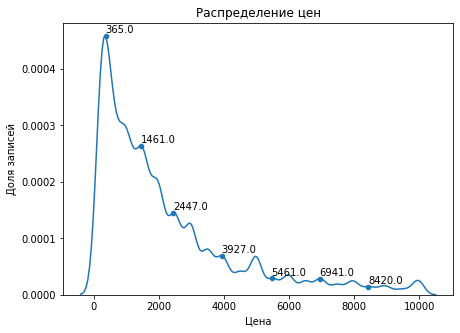

In [10]:
plt.figure(figsize=(7, 5))
ax = sns.kdeplot(df[df['price'].between(100, 10000)]['price'])
xlabels = ax.lines[0].get_xdata()
ylabels = ax.lines[0].get_ydata()

max_y_i = [
    (ylabels[i], i) 
    for i in range(1, len(ylabels)-1) 
    if ylabels[i-1] <= ylabels[i] and ylabels[i] >= ylabels[i+1]]

del max_y_i[3]
del max_y_i[3]
del max_y_i[4]
del max_y_i[4]
del max_y_i[5]
del max_y_i[5]
del max_y_i[6]
del max_y_i[6]
del max_y_i[7]
del max_y_i[7]


sns.scatterplot(list(map(lambda x: xlabels[x[1]], max_y_i)), list(map(lambda x: x[0], max_y_i)))

for y, i in max_y_i[:10]:
    x = xlabels[i]  
    ax.annotate(np.round(x, 0), (x, y+0.000005))
    
ax.set(xlabel='Цена', ylabel='Доля записей', title='Распределение цен')

In [11]:
df_prices_coordinates = df.merge(df_locations[['square_contain_id', 'topic', 'latitude', 'longitude']], on='square_contain_id', how='left').drop_duplicates().dropna()

In [12]:
df_prices_coordinates.topic = df_prices_coordinates.topic.apply(eval)

In [13]:
df_prices_coordinates = df_prices_coordinates.explode('topic')

In [14]:
df_grouped = df_prices_coordinates.groupby(['square_contain_id']).agg({'price': ['min', 'median', 'max'], 'latitude': ['min'], 'longitude': ['min']})

In [15]:
df_grouped

price                   latitude  longitude
                    min  median     max        min        min
square_contain_id                                            
56384.0             180  1895.0   71000  60.041502  30.325467
56455.0             100  2385.0   20000  60.041223  30.389278
57750.0             260  1600.0   82500  60.040585  30.407930
57800.0             100  1350.0  315000  60.040426  30.453263
58294.0             100  2590.0  239590  60.039948  30.324894
...                 ...     ...     ...        ...        ...
356645.0            100  2440.0  300000  59.829482  30.535731
357071.0            100  3250.0  838625  59.829050  30.346300
357107.0            100  1990.0   30400  59.829213  30.378233
357153.0            100  1835.0   38000  59.828820  30.419760
364331.0            100  2000.0  150000  59.823862  30.573066

[1632 rows x 5 columns]

In [16]:
class ZeroOneScaler:
    def __init__(self):
        self.min = None
        self.max = None

    def fit_transform(self, X):
        self.min = X.min()
        self.max = X.max()
        
        return (X - self.min) / (self.max - self.min)

In [17]:
df_grouped_balanced = df_grouped[df_grouped['price']['min'].between(100, 10000) |
                                 df_grouped['price']['max'].between(100, 10000) |
                                 df_grouped['price']['median'].between(100, 10000)].copy()

In [18]:
scaler = ZeroOneScaler()

prices_min = scaler.fit_transform(df_grouped_balanced['price']['min']).values
prices_max = scaler.fit_transform(df_grouped_balanced['price']['max']).values
prices_mean = scaler.fit_transform(df_grouped_balanced['price']['median']).values

In [19]:
df_grouped_balanced['price_normalized_min'] = prices_min
df_grouped_balanced['price_normalized_max'] = prices_max
df_grouped_balanced['price_normalized_median'] = prices_mean

In [20]:
import seaborn as sns

In [25]:
import os
import random

from ipywidgets import HTML, interact
from ipyleaflet import Map, GeoJSON, basemaps, Marker, Heatmap, Circle
from random import uniform
from ipywidgets.embed import embed_minimal_html


saint_petersburg_coordinates = (59.927628, 30.317613)

@interact(parameter=['Минимальные цены', 'Максимальные цены', 'Медианные цены'])
def plot_map_with_filter(parameter):
    parameter = {'Минимальные цены': 'min', 'Максимальные цены': 'max', 'Медианные цены': 'median'}.get(parameter)
    
    formulas = {
        'min': lambda x: x,
        'max': lambda x: x,
        'median': lambda x: x
    }
    
    koefs = {
        'min': 5000,
        'max': 5000,
        'median': 1000
    }
    
    m = Map(center=saint_petersburg_coordinates, zoom=10)

    heatmap = Heatmap(
        locations=[
            [
                row['latitude']['min'], 
                row['longitude']['min'], 
                row['price'][parameter]
            ] for row in df_grouped_balanced.iloc],
        radius=8,
    )

    m.add_layer(heatmap)

    return m

interactive(children=(Dropdown(description='parameter', options=('Минимальные цены', 'Максимальные цены', 'Мед…